In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.4 ; cuda:  cu124
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, matplotlib.pyplot as plt


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Helper functions

In [3]:
def cv2_imshow(img):
    """
    Displays an image in a Jupyter notebook using matplotlib.

    Args:
        image_path (str): Path to the image file.
    """

    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Image at {image_path} not found or failed to load.")
        return
    
    # Convert the image from BGR to RGB for correct display with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off the axis labels
    plt.show()

def read_random_image(directory_path):
    # Get a list of all files in the directory
    all_files = os.listdir(directory_path)
    
    # Filter out the image files (commonly supported formats)
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [file for file in all_files if any(file.lower().endswith(ext) for ext in image_extensions)]
    
    if not image_files:
        raise ValueError("No image files found in the directory.")
    
    # Choose a random image file
    random_image = random.choice(image_files)
    
    # Construct the full path to the image
    image_path = os.path.join(directory_path, random_image)
    
    # Read the image using cv2
    img = cv2.imread(image_path)
    
    if img is None:
        raise ValueError("Failed to read the image file.")
    
    return img

# Standard Detectron2 Run

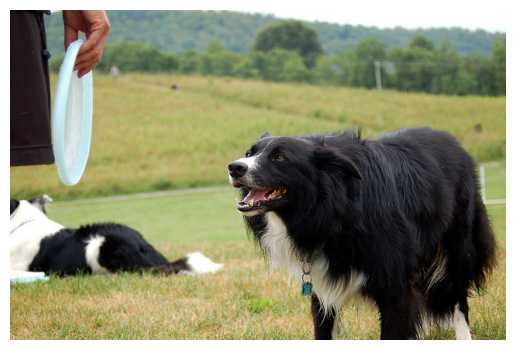

In [4]:
# Use image from local person coco dataset
im = read_random_image("./person")
cv2_imshow(im)

In [5]:
# Then, we create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image.
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[09/22 15:02:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/taiga/conda/envs/clowder2-extractors/lib/python3.10/site-packages/detectron2/layers/wrappers.py:46: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return is_compiling()
/taiga/conda/envs/clowder2-extractors/lib/python3.10/site-packages/detectron2/layers/wrappers.py:46: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return is_compiling()
/taiga/conda/envs/clowder2-extractors/lib/python3.10/site-packages/detectron2/layers/wrappers.py:46: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return is_compiling()
/taiga/conda/envs/clowder2-extractors/lib/python3.10/site-packages/detectron2/layers/wrappers.py:46: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return is_compiling()
/taiga/conda/envs/clowder2-extra

In [6]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([16,  0, 29, 16,  0, 19], device='cuda:0')
Boxes(tensor([[2.7851e+02, 1.5200e+02, 6.2856e+02, 4.2575e+02],
        [7.1581e-02, 6.2357e-01, 1.3138e+02, 2.0155e+02],
        [5.1046e+01, 4.4377e+01, 1.0496e+02, 2.2968e+02],
        [0.0000e+00, 2.3261e+02, 2.7500e+02, 3.4846e+02],
        [1.2863e+02, 6.9125e+01, 1.4170e+02, 9.4132e+01],
        [0.0000e+00, 2.3517e+02, 2.7703e+02, 3.4544e+02]], device='cuda:0'))


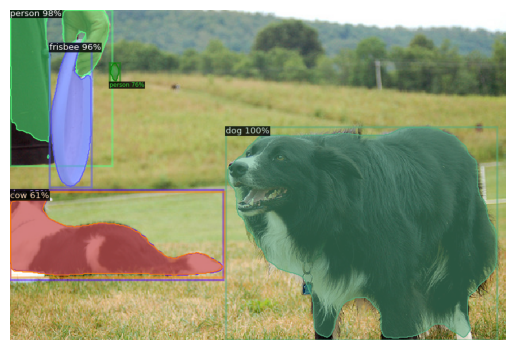

In [7]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Ray Batch Inference

## Create Ray Dataset

In [12]:
import ray
ray.init(_temp_dir='/taiga/mohanar2/raytmp', ignore_reinit_error=True)

ds = ray.data.read_images("./person")
display(ds.schema())


2024-09-22 15:18:07,971	INFO worker.py:1744 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Column  Type
------  ----
image   numpy.ndarray(shape=(426, 640, 3), dtype=uint8)

In [13]:
single_batch = ds.take_batch(batch_size=3)
display(single_batch)

2024-09-22 15:18:46,961	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /taiga/mohanar2/raytmp/session_2024-09-22_15-18-01_883626_232012/logs/ray-data
2024-09-22 15:18:46,962	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> LimitOperator[limit=3]


- ReadImage->SplitBlocks(4) 1:   0%|          | 0/12 [00:00<?, ?it/s]

- limit=3 2:   0%|          | 0/12 [00:00<?, ?it/s]

Running 0:   0%|          | 0/12 [00:00<?, ?it/s]

{'image': array([array([[[ 77, 132, 233],
                [ 78, 133, 234],
                [ 78, 133, 234],
                ...,
                [ 63, 113, 210],
                [ 65, 113, 211],
                [ 66, 114, 212]],
 
               [[ 79, 134, 235],
                [ 79, 134, 235],
                [ 79, 134, 235],
                ...,
                [ 64, 114, 211],
                [ 65, 113, 211],
                [ 64, 112, 210]],
 
               [[ 80, 135, 235],
                [ 80, 135, 235],
                [ 80, 135, 235],
                ...,
                [ 64, 114, 211],
                [ 64, 112, 210],
                [ 63, 111, 209]],
 
               ...,
 
               [[ 36,  26,  17],
                [ 39,  29,  20],
                [ 44,  34,  25],
                ...,
                [ 53,  46,  36],
                [ 46,  35,  29],
                [ 56,  43,  37]],
 
               [[ 47,  32,  25],
                [ 42,  29,  21],
               

In [11]:
class RayDetectronModel:
    def __init__(self, 
                 config_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", 
                 checkpoint_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
                 threshold = 0.5):
        # Define the model loading and initialization code in `__init__`.
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file(config_file))
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_file)
        self.predictor = DefaultPredictor(cfg)
    
    def __call__(self, batch_images):
        # Define the model inference code in `__call__`.
        results =  [self.predictor(im) for im in batch_images]
        return results

In [ ]:
ds = ds.map_batches(RayDetectronModel,
                    concurrent = 1,
                    batch_size = 3,
                    num_gpus = 1)

In [ ]:
batch = ds.take_batch(batch_size=3)
for im in batch:
    cv2_imshow(im)